> Name: 張宸愷
> ID: 0710018

In [93]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

#-------------------------#
# Some parameters
PCA = True
bin_5_classf = 0


#-------------------------#

df = pd.read_csv("data/student-mat.csv", sep=";")  # read csv. I used the
# mathematics dataset


cats = df.select_dtypes(include=[object])  # select categorical features
num = df.select_dtypes(include=[int])  # select numerical features
cats = pd.get_dummies(cats)  # onehot encode

# combine numerical and categorical data
data_orig = pd.concat([cats, num], axis=1)

if bin_5_classf == 0:

    classes = ["pass", "fail"]
    data_orig['G3'] = data_orig['G3'].apply(
        lambda x: "pass" if x > 10 else "fail")

elif bin_5_classf == 1:
    num["G3"] = []
    classes = ["I", "II", "III", "IV", "V"]

data = data_orig.to_numpy()  # get the binary classification data
# np.random.shuffle(data)
clss = len(classes)
feature_num = data.shape[1]-1
# print(data_orig.head())



In [94]:
# Decision tree

def r2np(r: dict):
    nn = np.ndarray((len(classes), 3))
    for index, c in enumerate(classes):
        nn[index] = [r[c]["precision"], r[c]["recall"], r["accuracy"]]

    # return [precision, recall, accuracy]
    return nn


def decision_t(training: np.ndarray, validation: np.ndarray):
    T_cls = tree.DecisionTreeClassifier()
    X_train, y_train = training[:, 0:feature_num], training[:, feature_num]
    X_test, y_test = validation[:, 0:feature_num], validation[:, feature_num] 
    T_cls.fit(X_train, y_train)
    y_pred = T_cls.predict(X_test)
    r = classification_report(y_test, y_pred, output_dict=True)
    c = confusion_matrix(y_test, y_pred, labels=classes)

    return r, c, T_cls


kfold = KFold(n_splits=3, shuffle=True)
T_cls = None
rs = np.zeros((len(classes), 3))
cs = np.zeros((clss, clss))
for train_index, test_index in kfold.split(data[:, 0:feature_num], data[:, feature_num]):
    r, confm, T_cls = decision_t(data[train_index], data[test_index])
    rs += r2np(r)
    cs += confm
# get average
rs = rs/3
cs = cs/3


# show data
rs = pd.DataFrame(rs, index=classes, columns=[
                  'precision', 'recall', 'accuracy'])
print("report classification")
print(rs)
cs = pd.DataFrame(cs, index=["true " + x for x in classes],
                  columns=["pred " + x for x in classes])
print("")
print("confusion matrix")
print(cs)





report classification
      precision    recall  accuracy
pass   0.902590  0.913719  0.901207
fail   0.901762  0.885629  0.901207

confusion matrix
           pred pass  pred fail
true pass  63.666667        6.0
true fail   7.000000       55.0


In [95]:
# Random forest

from sklearn.ensemble import RandomForestClassifier

#-------------------------#
# some parameters
num_trees = 50


#-------------------------#

R_cls = None

rs = np.zeros((clss, 3))
cs = np.zeros((clss, clss))


def random_f_1(training: np.ndarray, validation: np.ndarray):
    y_pred = []
    for i in range(num_trees):
        T_cls = tree.DecisionTreeClassifier()
        select_i = np.arange(feature_num)
        np.random.shuffle(select_i)
        select_i = select_i[0:30]
        X_train, y_train = training[:, select_i], training[:, feature_num]
        X_test = validation[:, select_i]
        T_cls.fit(X_train, y_train)
        y_pred.append(T_cls.predict(X_test))

    y_pred = np.array(y_pred, dtype=str).T
    # print(y_pred)
    y = []
    for i in range(y_pred.shape[0]):
        un = np.array(np.unique(y_pred[i], return_counts=True)).T
        m = np.argmax(un[:,1])
        # print(un[m,0])
        y.append(un[m,0])
    y = np.array(y)
    y_test = validation[:, feature_num]
    r = classification_report(y_test, y, output_dict=True)
    c = confusion_matrix(y_test, y, labels=classes)

    return r, c, None


def random_f(training: np.ndarray, validation: np.ndarray):
    R_cls = RandomForestClassifier(num_trees)
    X_train, y_train = training[:, 0:feature_num], training[:, feature_num]
    X_test, y_test = validation[:, 0:feature_num], validation[:, feature_num] 
    R_cls.fit(X_train, y_train)
    y_pred = R_cls.predict(X_test)
    r = classification_report(y_test, y_pred, output_dict=True)
    c = confusion_matrix(y_test, y_pred, labels=classes)
    return r, c, None

kfold = KFold(n_splits=3, shuffle=True)
R_cls = None
rs = np.zeros((len(classes), 3))
cs = np.zeros((clss, clss))
for train_index, test_index in kfold.split(data[:, 0:feature_num], data[:, feature_num]):
    r, confm, R_cls = random_f(data[train_index], data[test_index])
    rs += r2np(r)
    cs += confm
rs = rs / 3
cs = cs / 3


# show data
rs = pd.DataFrame(rs, index=classes, columns=[
                  'precision', 'recall', 'accuracy'])
print("report classification")
print(rs)
cs = pd.DataFrame(cs, index=["true " + x for x in classes],
                  columns=["pred " + x for x in classes])
print("")
print("confusion matrix")
print(cs)





report classification
      precision    recall  accuracy
pass   0.947222  0.938449  0.939163
fail   0.928704  0.938658  0.939163

confusion matrix
           pred pass  pred fail
true pass  65.333333   4.333333
true fail   3.666667  58.333333


In [98]:
from sklearn.neighbors import KNeighborsClassifier

#-----------------------#
# some parameters
K_n = 3

#-----------------------#



def knn_r(training:np.ndarray, validation:np.ndarray):
    knn = KNeighborsClassifier(n_neighbors=K_n)
    X_train, y_train = training[:, 0:feature_num], training[:, feature_num]
    X_test, y_test = validation[:, 0:feature_num], validation[:, feature_num] 
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    r = classification_report(y_test, y_pred, labels=classes, output_dict=True)
    c = confusion_matrix(y_test, y_pred, labels=classes)

    return r, c, knn
    

kfold = KFold(n_splits=3, shuffle=True)
knn = None
rs = np.zeros((len(classes), 3))
cs = np.zeros((clss, clss))
for train_index, test_index in kfold.split(data[:, 0:feature_num], data[:, feature_num]):
    r, confm, knn = knn_r(data[train_index], data[test_index])
    rs += r2np(r)
    cs += confm
rs = rs / 3
cs = cs / 3




# show data
rs = pd.DataFrame(rs, index=classes, columns=[
                  'precision', 'recall', 'accuracy'])
print("report classification")
print(rs)
cs = pd.DataFrame(cs, index=["true " + x for x in classes],
                  columns=["pred " + x for x in classes])
print("")
print("confusion matrix")
print(cs)








report classification
      precision    recall  accuracy
pass   0.887731  0.887373  0.883491
fail   0.880109  0.878399  0.883491

confusion matrix
           pred pass  pred fail
true pass  62.000000   7.666667
true fail   7.666667  54.333333


# Qestions

## Q1 Decision Tree
> Show the prediction and reasoning of one arbitrary sample in the testing set. - 10%



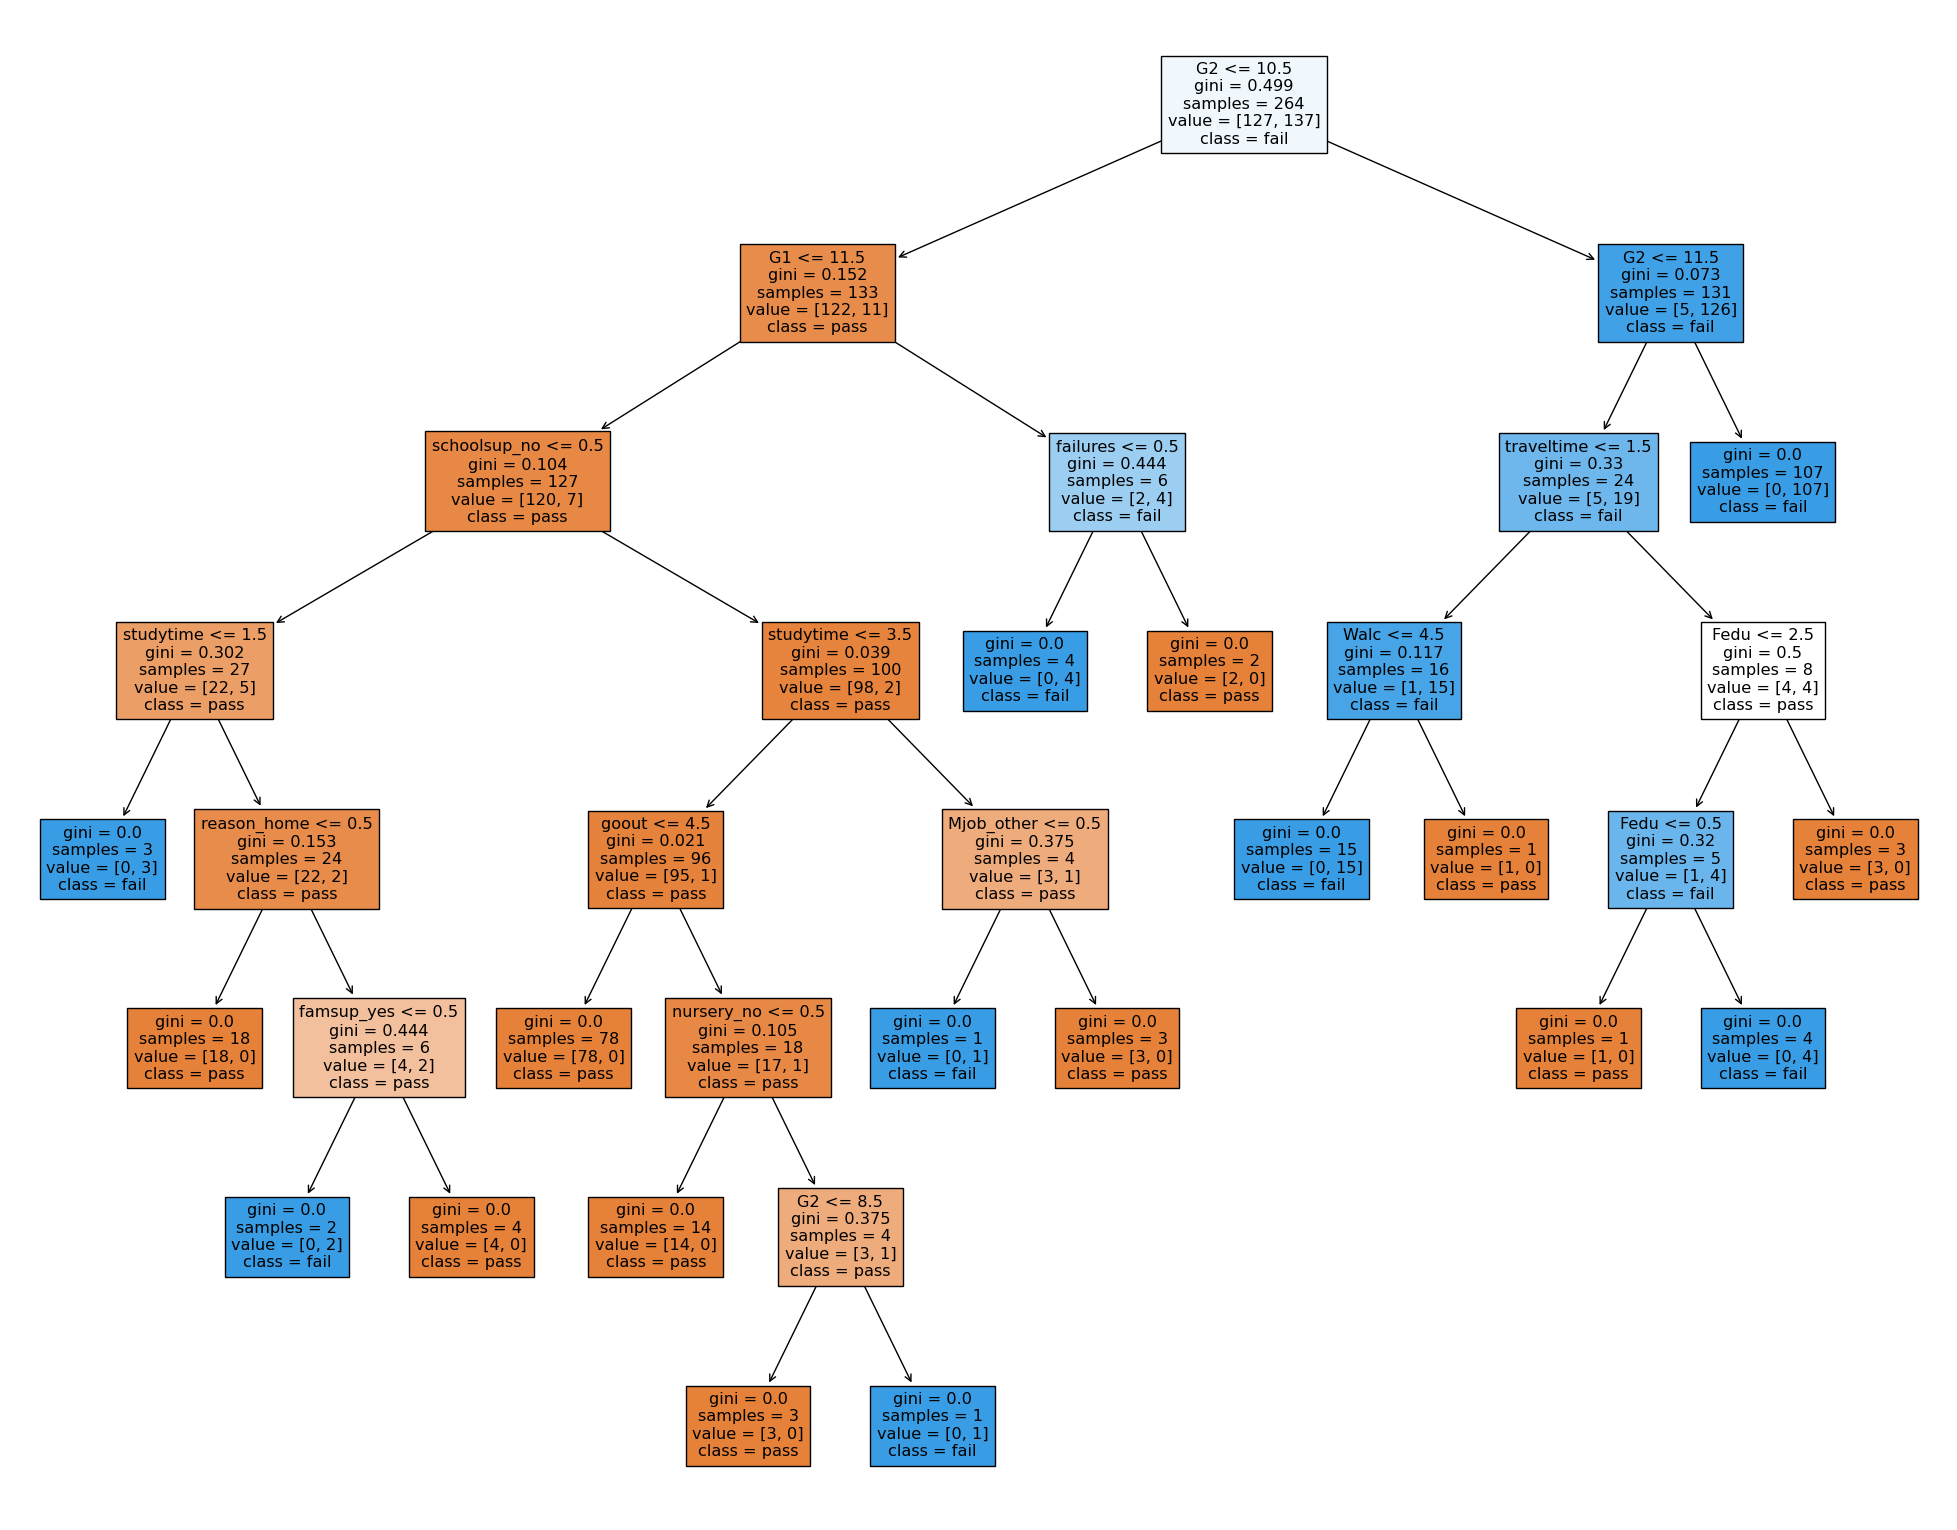

In [96]:

fig = plt.figure(figsize=(25, 20), dpi=100)
_ = tree.plot_tree(T_cls, feature_names=data_orig.columns,
                      class_names=classes,
                       filled=True)
